In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap
from activ.clustering import UmapClusteringResults
from os.path import dirname, join
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
f = h5py.File('/Users/ahyeon/Desktop/activ misc/predict_scores2.h5', 'r')

In [3]:
predictions = f['score'][:]
norm_predictions = f['norm_score'][:]
labels = f['clusters'][:]
umap_dims = f['umap_dimensions'][:]
cluster_sizes = f['cluster_sizes'][:]

In [4]:
predictions.shape

(50, 49, 247)

In [140]:
def conf_alliter(size, predicted, actual):
    confalliter = []
    for j in range(50):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

In [141]:
def accuracy(mat):
    return mat.trace()/mat.sum()

def specificity(tn, fp):
    return tn/(tn+fp)

def sensitivity(tp, fn):
    return tp/(tp+fn)

def fscore(tp, fp, fn):
    return (2*tp)/(2*tp+fp+fn)

In [142]:
def ind_statistics(matrix):
    mat = np.matrix(matrix)
    allvals=[]
    tps = []
    tns = []
    fps = []
    fns = []
    for i in range(mat.shape[0]):
        tp = mat[i,i]
        tn = mat.sum() - mat[i,:].sum() - mat[:,i].sum() + mat[i,i]
        fp = mat[:,i].sum() - mat[i,i]
        fn = mat[i,:].sum() - mat[i,i]
        tps.append(tp)
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
    allvals.append(tps)
    allvals.append(tns)
    allvals.append(fps)
    allvals.append(fns)
    return allvals

In [143]:
def find_avg_spec(array):
    allspec = []
    for i in range(len(array[0])):
        vals = []
        for elem in array:
            vals.append(elem[i])
        tp = vals[0]
        tn = vals[1]
        fp = vals[2]
        fn = vals[3]
        spec = specificity(tn, fp)
        allspec.append(spec)
    allspec_mean = np.mean(allspec)
    return(allspec_mean)

In [144]:
def find_avg_sens(array):
    allsens = []
    for i in range(len(array[0])):
        vals = []
        for elem in array:
            vals.append(elem[i])
        tp = vals[0]
        tn = vals[1]
        fp = vals[2]
        fn = vals[3]
        sens = sensitivity(tp, fn)
        allsens.append(sens)
    allsens_mean = np.mean(allsens)
    return(allsens_mean)

In [145]:
def find_avg_fscore(array):
    allf = []
    for i in range(len(array[0])):
        vals = []
        for elem in array:
            vals.append(elem[i])
        tp = vals[0]
        tn = vals[1]
        fp = vals[2]
        fn = vals[3]
        f = fscore(tp, fp, fn)
        allf.append(f)
    allf_mean = np.mean(allf)
    return(allf_mean)


In [147]:
# accuracy
fold_over_chance = np.zeros((len(cluster_sizes), 50))

for ii,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [x/y for x, y in zip(acc, norm_acc)]
    fold_over_chance[ii,:] = foc


/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


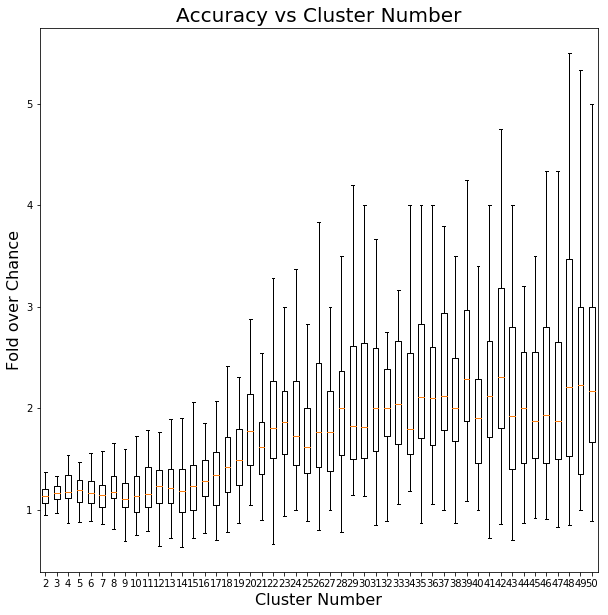

In [148]:
plt.figure(figsize=(10,10))
plt.boxplot(fold_over_chance.T, labels = cluster_sizes, showfliers=False)
plt.xlabel('Cluster Number', fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Accuracy vs Cluster Number', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/acc_vs_clusters_predictions.pdf')

In [49]:
# avg sensitivity

sens_arr = np.zeros((len(cluster_sizes), 50))
for ii, c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    sens_50 = []
    norm_sens_50 = []
    for i in range(50):
        x = ind_statistics(all50mat[i])
        y = ind_statistics(norm_all50mat[i])
        sens = find_avg_sens(x)
        norm_sens = find_avg_sens(y)
        sens_50.append(sens)
        norm_sens_50.append(norm_sens)
    foc = [j/k for j,k in zip(sens_50, norm_sens_50)]
    sens_arr[ii,:] = foc
    

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


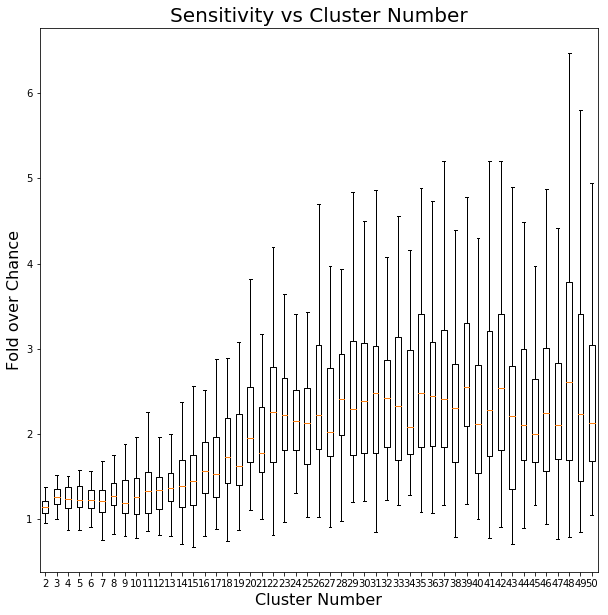

In [205]:
plt.figure(figsize=(10,10))
plt.boxplot(sens_arr.T, labels = cluster_sizes, showfliers=False)
plt.xlabel('Cluster Number', fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Sensitivity vs Cluster Number', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/sens_vs_clusters_predictions.pdf')

In [50]:
# avg fscore

f_arr = np.zeros((len(cluster_sizes), 50))
for ii, c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    f_50 = []
    norm_f_50 = []
    for i in range(50):
        x = ind_statistics(all50mat[i])
        y = ind_statistics(norm_all50mat[i])
        f = find_avg_fscore(x)
        norm_f = find_avg_fscore(y)
        f_50.append(f)
        norm_f_50.append(norm_f)
    foc = [j/k for j,k in zip(f_50, norm_f_50)]
    f_arr[ii,:] = foc

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


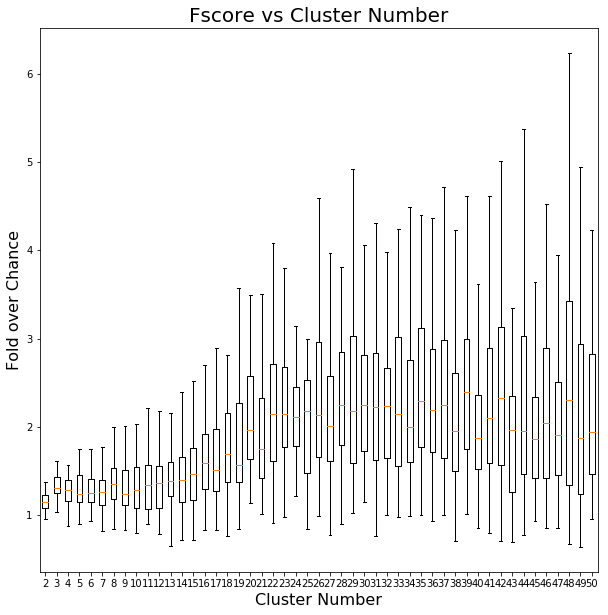

In [207]:
plt.figure(figsize=(10,10))
plt.boxplot(f_arr.T, labels = cluster_sizes, showfliers=False)
plt.xlabel('Cluster Number', fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Fscore vs Cluster Number', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/fscore_vs_clusters_predictions.pdf')

In [155]:
# avg specificity

spec_arr = np.zeros((len(cluster_sizes), 50, 3))
for ii, c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    spec_50 = []
    norm_spec_50 = []
    for i in range(50):
        x = ind_statistics(all50mat[i])
        y = ind_statistics(norm_all50mat[i])
        spec = find_avg_spec(x)
        norm_spec = find_avg_spec(y)
        spec_50.append(spec)
        norm_spec_50.append(norm_spec)
    foc = [j/k for j,k in zip(spec_50, norm_spec_50)]
    spec_arr[ii,:,0] = foc
    spec_arr[ii,:,1] = spec_50
    spec_arr[ii,:,2] = norm_spec_50

In [34]:
spec_arr[:,:,2]

array([[ 0.54156824,  0.54156824,  0.54156824, ...,  0.54156824,
         0.54156824,  0.54156824],
       [ 0.66942781,  0.66942781,  0.66942781, ...,  0.66942781,
         0.66942781,  0.66942781],
       [ 0.7411806 ,  0.7411806 ,  0.7411806 , ...,  0.7411806 ,
         0.7411806 ,  0.7411806 ],
       ..., 
       [ 0.97879925,  0.97879925,  0.97879925, ...,  0.97879925,
         0.97879925,  0.97879925],
       [ 0.97939605,  0.97939605,  0.97939605, ...,  0.97939605,
         0.97939605,  0.97939605],
       [ 0.9799914 ,  0.9799914 ,  0.9799914 , ...,  0.9799914 ,
         0.9799914 ,  0.9799914 ]])

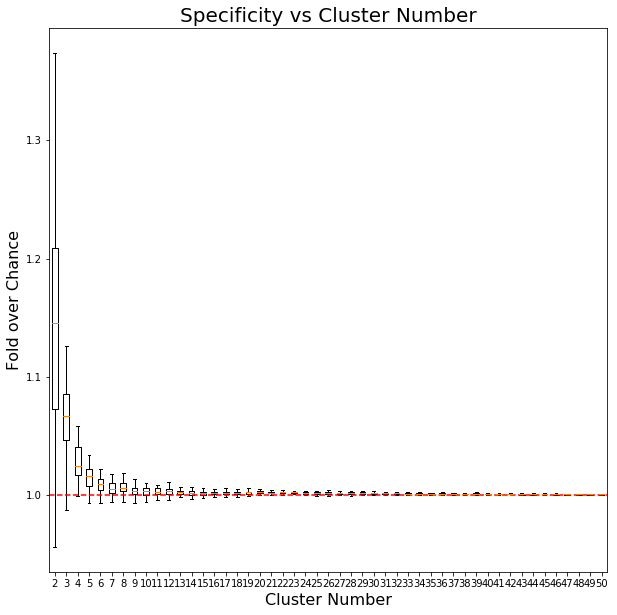

In [165]:

fig, ax = plt.subplots(figsize=(10,10))
a = ax.boxplot(spec_arr[:,:,0].T, labels = cluster_sizes, showfliers=False)
ax.axhline(y=1, color='r', linestyle = '--')
ax.set_xlabel('Cluster Number', fontsize=16)
ax.set_ylabel('Fold over Chance', fontsize=16)
ax.set_title('Specificity vs Cluster Number', fontsize=20)

plt.savefig('/Users/ahyeon/Desktop/activ misc/spec_vs_clusters_predictions.pdf')


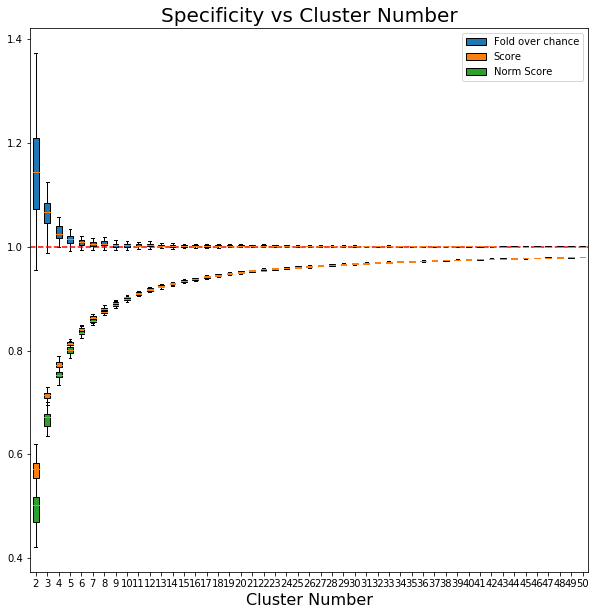

In [160]:

fig, ax = plt.subplots(figsize=(10,10))
a = ax.boxplot(spec_arr[:,:,0].T, labels = cluster_sizes, showfliers=False, patch_artist=True, boxprops=dict(facecolor="C0"))
b = ax.boxplot(spec_arr[:,:,1].T, labels=cluster_sizes, showfliers=False, patch_artist=True, boxprops=dict(facecolor="C1"))
c = ax.boxplot(spec_arr[:,:,2].T, labels=cluster_sizes, showfliers=False, patch_artist=True, boxprops=dict(facecolor="C2"))
ax.axhline(y=1, color='r', linestyle = '--')
ax.set_xlabel('Cluster Number', fontsize=16)
ax.set_title('Specificity vs Cluster Number', fontsize=20)

ax.legend([a["boxes"][0],b["boxes"][0],c["boxes"][0]], ['Fold over chance', 'Score', 'Norm Score'], loc='upper right')
plt.savefig('/Users/ahyeon/Desktop/activ misc/spec_vs_clusters_predictions.pdf')


In [150]:
acc = np.median(fold_over_chance,axis=1)
sens = np.median(sens_arr,axis=1)
fscore = np.median(f_arr,axis=1)

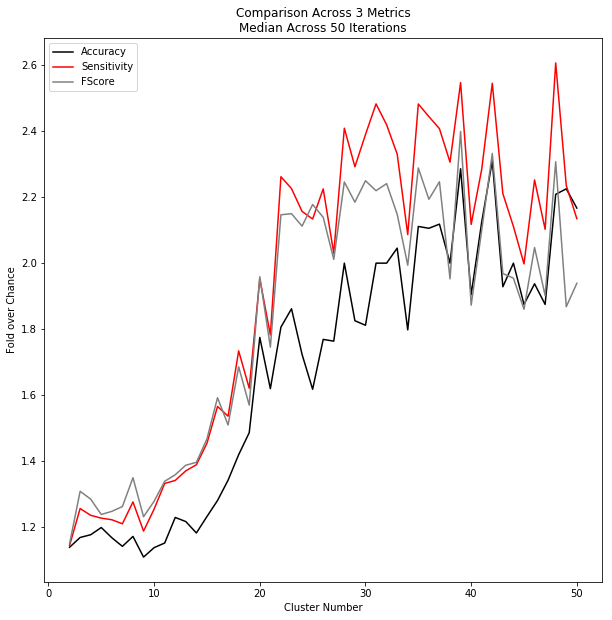

In [152]:
plt.figure(figsize=(10,10))
plt.plot(cluster_sizes, acc,  color='black', label='Accuracy')
plt.plot(cluster_sizes, sens, color='red', label='Sensitivity')
plt.plot(cluster_sizes, fscore, color='grey', label='FScore')
plt.legend()
plt.xlabel('Cluster Number')
plt.ylabel('Fold over Chance')
plt.title('Comparison Across 3 Metrics\nMedian Across 50 Iterations')
plt.savefig('/Users/ahyeon/Desktop/activ misc/acc_comparison_plot.pdf')